# Orbit Determination

## Import module

In [1]:
from math import *
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd

from astropy.coordinates import EarthLocation
from astropy.time import Time
from astropy import units as u
from datetime import datetime

import sympy

## Define Vector

In [2]:
class Vector:
    _isrealnumber = lambda x : isinstance(x, int) or isinstance(x, float)
    __slots__ = ('x', 'y', 'z')
    def __init__(self, x, y, z = 0.0):
        if all(map(Vector._isrealnumber, (x, y, z))):
            self.x, self.y, self.z = map(float, (x, y, z))
    def __repr__(self):
        return f'Vector({self.x:.04f}, {self.y:.04f}, {self.z:.04f})'
    def norm(self):
        return (self.x**2 + self.y**2 + self.z**2)**0.5
    @property
    def norm(self):
        return (self.x**2 + self.y**2 + self.z**2)**0.5
    @norm.setter
    def norm(self, value):
        self.x, self.y, self.z = value, 0, 0
    @property
    def _comps(self):
        return (self.x, self.y, self.z)
    @property
    def norm(self):
        return sum(i*i for i in self._comps) ** 0.5
    def __repr__(self):
        return "Vector({:.04f}, {:.04f}, {:.04f})".format(*self._comps)
    def multiplied(self, k):
        return Vector(*(i*k for i in self._comps))
    def __mul__(self, k):
        if Vector._isrealnumber(k):
            return self.multiplied(k)
    def __rmul__(self, k):
        return self*k
    def __truediv__(self, k):
        if Vector._isrealnumber(k):
            return self.multiplied(1/k)
    def __neg__(self):
        return Vector(*(-i for i in self._comps))
    def __add__(self, other):
        return Vector(*(i+j for i, j in zip(self._comps, other._comps)))
    def __radd__(self, other):
        return self._add(other) 
    def __sub__(self, other):
        return self + -other
    def __rsub__(self, other):
        return -self + other
    def dot(self, other):
        return sum(i*j for i,j in zip(self._comps, other._comps))
    def cross(self, other):
        return Vector(self.y * other.z - self.z * other.y, self.z * other.x - self.x * other.z, self.x * other.y - self.y * other.x)
    def __mul__(self, other):
        if Vector._isrealnumber(other):
            return self.multiplied(other)
        if isinstance(other, Vector):
            return self.cross(other)
    def __matmul__(self, other):
        if isinstance(other, Vector):
            return self.dot(other)
    @property
    def hat(self):
        return self * (1/self.norm)

#벡터 a, b와 실수 k에 대해,
#정의: a = Vector(ax, ay, az)
#크기: a.norm
#성분: a.x, a.y, a.z
#실수배: a * k
#실수로 나누기: a / k
#역벡터: -a
#덧셈: a + b
#뺄셈: a - b
#내적: a @ b
#외적: a * b
#단위벡터: a.hat

## Input

In [3]:
lam = 127.005427        # 관측자 경도(deg)
phi = 37.308807         # 관측자 위도(deg)
H = 0.098               # 관측자 고도(km)

Data = [['2023-02-25 00:00:00','12:44:50.94','12:53:47.4'],    # example(Ceres)
        ['2023-02-26 00:00:00','12:44:24.29','13:00:26.3'], 
        ['2023-02-27 00:00:00','12:43:56.13','13:07:6.7']]     # UTC 관측시각(YYYY-MM-DD hh:mm:ss), 적경(hh:mm:ss...), 적위(dd:mm:ss...)

## Set System

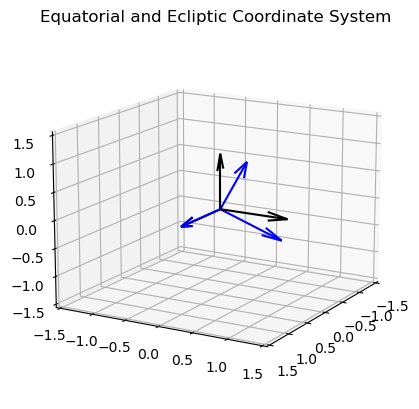

In [7]:
mu = 1.98892e+30 * 6.6738e-11 / 10**9
eps = 23.5

R_e = 6378
f = 1/299

Rp_E = 1.471e+8     # 지구 근일점 거리
e_E = 0.0167086     # 지구 이심률

I_hat = Vector(1,0,0)       # 황도좌표계
J_hat = Vector(0,1,0)
K_hat = Vector(0,0,1)

i_hat = I_hat       # 적도좌표계
j_hat = Vector(0,cos(radians(eps)),-sin(radians(eps)))
k_hat = Vector(0,sin(radians(eps)),cos(radians(eps)))

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.view_init(elev = 15, azim = 30)

xyzlim3d = 1.5
ax.set_xlim3d(-xyzlim3d,xyzlim3d)
ax.set_ylim3d(-xyzlim3d,xyzlim3d)
ax.set_zlim3d(-xyzlim3d,xyzlim3d)

ax.set_title('Equatorial and Ecliptic Coordinate System')

def plotVec(Vec, col):
    ax.quiver(0,0,0, Vec.x,Vec.y,Vec.z, color = col)

plotVec(I_hat, 'black')
plotVec(J_hat, 'black')
plotVec(K_hat, 'black')

plotVec(i_hat, 'blue')
plotVec(j_hat, 'blue')
plotVec(k_hat, 'blue')

## Data Organization

In [8]:
t = [datetime.strptime(data[0],'%Y-%m-%d %H:%M:%S') for data in Data]
RaDec = []
theta = []
for data in Data:
    RAh, RAm, RAs = data[1].split(':'); RAh, RAm, RAs = float(RAh), float(RAm), float(RAs)
    Decd, Decm, Decs = data[2].split(':'); Decd, Decm, Decs = float(Decd), float(Decm), float(Decs)
    if Decd<0:  Decm, Decs = -Decm, -Decs
    RaDec.append([(RAh + RAm/60 + RAs/3600)*360/24, Decd + Decm/60 + Decs/3600])

    obs_time = Time(data[0], scale = 'utc', location = EarthLocation(lat = phi*u.deg, lon = lam*u.deg))
    lst = float(str(obs_time.sidereal_time('apparent')*u.deg).replace(' deg hourangle',''))*360/24      # local sidereal time
    theta.append(lst)

df = pd.DataFrame.from_dict([RaDec[i][0],RaDec[i][1],theta[i]] for i in [0,1,2])
df = df.set_axis(['적경(deg)', '적위(deg)', '항성시(deg)'], axis = 1)
df

,적경(deg),적위(deg),항성시(deg)
0,191.212250,12.896500,281.604932
1,191.101208,13.007306,282.590570
2,190.983875,13.118528,283.576222


## Earth's location & Observer location

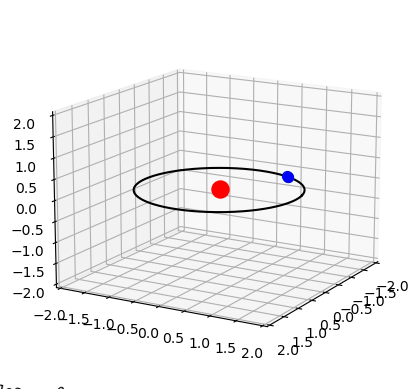

In [9]:
R_E_vec = []
for data in Data:
    obs_datetime_str = data[0]    # 세계시

    obs_time = Time(obs_datetime_str, scale = 'utc', location = EarthLocation(lat = 0*u.deg, lon = 0*u.deg))
    gst = str(obs_time.sidereal_time('apparent', 'greenwich'))   # greenwich sidereal time

    UTh, UTm, UTs = obs_datetime_str[11:].split(':'); UTh, UTm, UTs = float(UTh), float(UTm), float(UTs)
    gsth, gstms = gst.split('h'); gstm, gsts = gstms[:-1].split('m'); gsth, gstm, gsts = float(gsth), float(gstm), float(gsts)
    E_rot = ((gsth - UTh - 12) + (gstm - UTm)/60 + (gsts - UTs)/3600)*360/24
    while E_rot<0: E_rot += 360

    theta_E = E_rot + 75.98570
    while theta_E>360:    theta_E -= 360

    R_E_hat = -cos(radians(E_rot))*I_hat - sin(radians(E_rot))*J_hat
    R_E = Rp_E*(1 + e_E)/(1 + e_E*cos(radians(theta_E)))
    R_E_vec.append(R_E*R_E_hat)

R_phi = R_e / sqrt(1 - (2*f - f**2)*(sin(phi*pi/180)**2))
R_e_vec = [(R_phi + H)*cos(radians(phi))*(cos(radians(theta))*i_hat + sin(radians(theta))*j_hat) + (R_phi*(1 - f)**2 + H)*sin(radians(phi))*k_hat for theta in theta]

R_vec = [R_E_vec[i] + R_e_vec[i] for i in [0,1,2]]

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.view_init(elev = 15, azim = 30)

xyzlim3d = 2e+8
ax.set_xlim3d(-xyzlim3d,xyzlim3d)
ax.set_ylim3d(-xyzlim3d,xyzlim3d)
ax.set_zlim3d(-xyzlim3d,xyzlim3d)

def plotDot(Vec, col, size):
    ax.scatter(Vec.x,Vec.y,Vec.z, color = col, s = size)

plotDot(Vector(0,0,0), 'red', 150)  # Sun
plotDot(R_E_vec[0], 'blue', 50)  # Earth0
plotDot(R_E_vec[1], 'blue', 50)  # Earth1
plotDot(R_E_vec[2], 'blue', 50)  # Earth2

p_E_hat = -cos(radians(75.98570))*I_hat + sin(radians(75.98570))*J_hat
q_E_hat = K_hat * p_E_hat

ano_E = np.arange(0,360,1)
r_E = Rp_E*(1 + e_E) / (1 + e_E*np.cos(ano_E*pi/180))
x_E = r_E * (np.cos(ano_E*pi/180)*p_E_hat.x + np.sin(ano_E*pi/180)*q_E_hat.x)
y_E = r_E * (np.cos(ano_E*pi/180)*p_E_hat.y + np.sin(ano_E*pi/180)*q_E_hat.y)

ax.plot(x_E,y_E,0, color = 'black')     # Earth Orbit

## Gauss Method(1)

In [79]:
rho_vec = [(cos(radians(radec[1]))*(cos(radians(radec[0]))*i_hat + sin(radians(radec[0]))*j_hat) + sin(radians(radec[1]))*k_hat).hat for radec in RaDec]

tau0, tau2, tau = float((t[0] - t[1]).days)*86400 + float((t[0] - t[1]).seconds), float((t[2] - t[1]).days)*86400 + float((t[2] - t[1]).seconds), float((t[2] - t[0]).days)*86400 + float((t[2] - t[0]).seconds)
p_vec = [rho_vec[1] * rho_vec[2], rho_vec[0] * rho_vec[2], rho_vec[0] * rho_vec[1]]

D0 = rho_vec[0] @ p_vec[0]
D = [[R_vec @ p_vec for p_vec in p_vec] for R_vec in R_vec]

A = 1/D0 * (-D[0][1]*tau2/tau + D[1][1] + D[2][1]*tau0/tau)
B = 1/(6*D0) * (D[0][1]*(tau2**2 - tau**2)*tau2/tau + D[2][1]*(tau**2 - tau0**2)*tau0/tau)
E = R_vec[1] @ rho_vec[1]

a = -(A**2 + 2*A*E + R_vec[1] @ R_vec[1])
b = -2*mu*B*(A + E)
c = -(mu**2)*(B**2)

## Solving Polynomial Equation

In [80]:
def func(x):
       return x**8 + a * x**6 + b * x**3 + c

x = sympy.symbols('x', positive = True)
r1 = float(sympy.solve(func(x), x)[-1])

print(f'f({r1}) = {func(r1)}')

f(374406315.58482856) = 9.41721503017442e+53


## Gauss Method(2)

In [81]:
rho = [float(1/D0 * ((6*(D[2][0]*tau0/tau2 + D[1][0]*tau/tau2)*r1**3 + mu*D[2][0]*(tau**2 - tau0**2)*tau0/tau2)/(6*r1**3 + mu*(tau**2 - tau2**2)) - D[0][0])), 
       float(A + mu*B/r1**3), 
       float(1/D0 * ((6*(D[0][2]*tau2/tau0 - D[1][2]*tau/tau0)*r1**3 + mu*D[0][2]*(tau**2 - tau2**2)*tau2/tau0)/(6*r1**3 + mu*(tau**2 - tau2**2)) - D[2][2]))]

r_vec = [R_vec[i] + rho_vec[i]*rho[i] for i in [0,1,2]]

f0 = 1 - 1/2*mu*tau0**2/r1**3
f2 = 1 - 1/2*mu*tau2**2/r1**3
g0 = tau0 - 1/6*mu*tau0**3/r1**3
g2 = tau2 - 1/6*mu*tau2**3/r1**3

v1_vec = (-f2*r_vec[0] + f0*r_vec[2])/(f0*g2 - f2*g0)

## Solving Kepler Equation

In [82]:
while True:
    r1, v1 = r_vec[1].norm, v1_vec.norm
    v_r1 = v1_vec @ r_vec[1].hat
    alp = 2/r1 - v1**2/mu

    def C(z):
        return (1 - cos(radians(sqrt(z))))/z
    def S(z):
        return (1 - sin(radians(sqrt(z)))/sqrt(z))/z

    x0 = sqrt(mu)*alp*tau0      # Newton-Rapson method
    while True:
        f_x0 = r1*v_r1/sqrt(mu) * x0**2 * C(alp * x0**2) + (1 - alp*r1) * x0**3 * S(alp * x0**2) + r1*x0 - sqrt(mu)*tau0
        fp_x0 = r1*v_r1/sqrt(mu)* x0 *(1 - alp* x0**2 *S(alp*x0**2)) + (1 - alp*r1) * x0**2 *C(alp * x0**2) + r1
        ratio = f_x0 / fp_x0
        if ratio <= 0.00000001:
            chi0 = x0
            break
        x0 = x0 - ratio
    x0 = sqrt(mu)*alp*tau2
    while True:
        f_x0 = r1*v_r1/sqrt(mu) * x0**2 * C(alp * x0**2) + (1 - alp*r1) * x0**3 * S(alp * x0**2) + r1*x0 - sqrt(mu)*tau2
        fp_x0 = r1*v_r1/sqrt(mu)* x0 *(1 - alp* x0**2 *S(alp*x0**2)) + (1 - alp*r1) * x0**2 *C(alp * x0**2) + r1
        ratio = f_x0 / fp_x0
        if ratio <= 0.00000001:
            chi2 = x0
            break
        x0 = x0 - ratio

    f0 = 1 - chi0**2/r1 * C(alp * chi0**2)
    f2 = 1 - chi2**2/r1 * C(alp * chi2**2)
    g0 = tau0 - 1/sqrt(mu) * chi0**3 * S(alp * chi0**2)
    g2 = tau2 - 1/sqrt(mu) * chi2**3 * S(alp * chi2**2)

    c0 = g2/(f0*g2 - f2*g0)
    c2 = -g0/(f0*g2 - f2*g0)

    rho_ud = [float(1/D0 * (-D[0][0] + D[1][0]/c0 - c2*D[2][0]/c0)), 
              float(1/D0 * (-c0*D[0][1] + D[1][1] - c2*D[2][1])),
              float(1/D0 * (-c0*D[0][2]/c2 + D[1][2]/c2 - D[2][2]))]

    r_vec_ud = [R_vec[i] + rho_vec[i]*rho[i] for i in [0,1,2]]
    v1_vec_ud = (-f2*r_vec_ud[0] + f0*r_vec_ud[2])/(f0*g2 - f2*g0)

    dif = sum((r_vec_ud[i] - r_vec[i]).norm for i in [0,1,2])
    r_vec = r_vec_ud; v_vec = v1_vec_ud
    if dif <= 0.001:
        break

r_vec = r_vec[1]
v_vec = v1_vec

Vector(-365862136.2256, 41290540.1028, 67971153.6188) Vector(-5.5695, -18.8819, 0.6220)


## Orbit Elements

In [83]:
r = r_vec.norm
v = v_vec.norm
v_r = v_vec @ r_vec.hat

k_vec = r_vec * v_vec; k = k_vec.norm
N_vec = k_hat * k_vec; N = N_vec.norm

e_vec = (1/mu)*((v * v - mu / r) * r_vec - r * v_r * v_vec); e = e_vec.norm

a = (k*k/mu) / (1 - e*e)

i = acos(k_vec.z/k_vec.norm)*180/pi
if i>=180:
    i = 360 - i

Om = acos(N_vec.x/N_vec.norm)*180/pi
if N_vec.y < 0:
    Om = 360 - Om

om = acos((N_vec @ e_vec)/(N * e))*180/pi
if e_vec.z < 0:
    om = 360 - om

theta = acos((r_vec @ e_vec)/(r * e))*180/pi
if v_r < 0:
    theta = 360 - theta

print(f'이심률: {e}\n장반경: {a/1.496e+8} AU\n경사각: {i} deg\n승교점 경도: {Om} deg\n근심점 이각: {om} deg\n진근점 이각: {theta} deg')       # 이심률, 긴반지름, 경사각, 승교점 경도, 근심점 이각, 진근점이각

이심률: 0.1992383773096068
장반경: 2.763088169279917 AU
경사각: 10.459727041142493 deg
승교점 경도: 23.68173467302198 deg
근심점 이각: 79.63853283238305 deg
진근점 이각: 72.41013051576603 deg


## Orbit Visualization

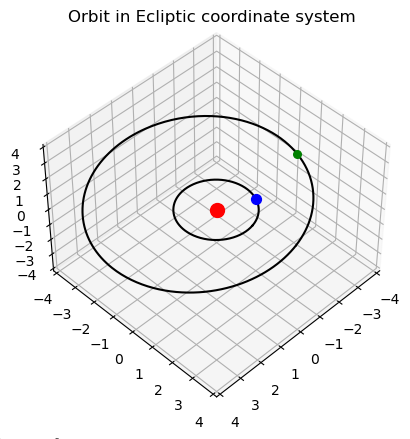

In [95]:
p_hat = e_vec.hat
q_hat = (k_vec * e_vec).hat

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.view_init(elev = 45, azim = 45)

ax.set_title('Orbit in Ecliptic coordinate system')

xyzlim3d = 4e+8
ax.set_xlim3d(-xyzlim3d,xyzlim3d)
ax.set_ylim3d(-xyzlim3d,xyzlim3d)
ax.set_zlim3d(-xyzlim3d,xyzlim3d)

def plotDot(Vec, col, size):
    ax.scatter(Vec.x,Vec.y,Vec.z, color = col, s = size)

plotDot(Vector(0,0,0), 'red', 100)  # Sun
plotDot(R_E_vec[1], 'blue', 50)  # Earth
plotDot(r_vec, 'green', 30) # Asteroid

ano_E = np.arange(0,360,1)
r_E = Rp_E*(1 + e_E) / (1 + e_E*np.cos(ano_E*pi/180))
x_E = r_E * (np.cos(ano_E*pi/180)*p_E_hat.x + np.sin(ano_E*pi/180)*q_E_hat.x)
y_E = r_E * (np.cos(ano_E*pi/180)*p_E_hat.y + np.sin(ano_E*pi/180)*q_E_hat.y)
ax.plot(x_E,y_E,0, color = 'black')     # Earth Orbit

ano = np.arange(0,360,1)
r = (k*k/mu) / (1 + e*np.cos(ano*pi/180))
x = r * (np.cos(ano*pi/180)*p_hat.x + np.sin(ano*pi/180)*q_hat.x)
y = r * (np.cos(ano*pi/180)*p_hat.y + np.sin(ano*pi/180)*q_hat.y)
z = r * (np.cos(ano*pi/180)*p_hat.z + np.sin(ano*pi/180)*q_hat.z)
ax.plot(x,y,z, color = 'black')     # Asteroid Orbit